### Ford Go Bike Data Visualization and Analysis
### by Sai Ogirala

### Investigation Overview:
In this Ford Go Bike Data Analysis,I want to investigate users behavior affecting Renting bikes. Main Focus was on Time ( Monthly,Weekdays, Hours), User Types and Age groups that Bikes are high in demand.

### About Dataset:
I chose Ford GoBike System Data : https://www.fordgobike.com/system-data as my source data This data set includes information about individual rides made in a bike-sharing system.Multiple data files will need to be joined together if a full year’s coverage is desired. The features included in the dataset : Trip Duration (seconds) , Start Time and Date , End Time and Date , Start Station ID , Start Station Name , Start Station Latitude , Start Station Longitude , End Station ID , End Station Name, End Station Latitude , End Station Longitude , Bike ID , User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual) , Member Year of Birth, Member Gender

In [2]:
# import all packages and set plots to be embedded inline
from requests import get
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import glob
import os
import math
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe
df_clean = pd.read_csv('master_bike_df.csv')

### Bike Rides Percentage by user type

In [7]:
customer = df_clean.query('user_type == "Customer"')['bike_id'].count()
subscriber = df_clean.query('user_type == "Subscriber"')['bike_id'].count()

customer_prop = customer / df_clean['bike_id'].count()
subscriber_prop = subscriber / df_clean['bike_id'].count()

Ford GoBike System currently offers 3 subscribtion types: Single Ride, Access Pass (24h or 72h) and Monthly Membership. Customers with a monthly membership ("Subscriber") make 88% of all users in FY 2018 and 12% were casual riders ("Customer") used ocasionally.

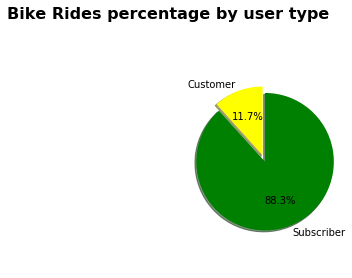

In [8]:
plt.subplot(1, 2, 2)

labels = ['Customer', 'Subscriber']
sizes = [customer_prop, subscriber_prop]
colors = ['yellow', 'green']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors = colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

plt.suptitle('Bike Rides percentage by user type', y=1.03, fontsize=16, fontweight='semibold');

### Monthly User Type Trends:

In [4]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

In [5]:
usertype_count_df = df_clean.groupby(["st_month", "user_type"]).size().reset_index()

It shows that mostly subscribers are using service, also customers slightly increased in summer time from May to october. However, both subscribers and customers service decrease during winter season.

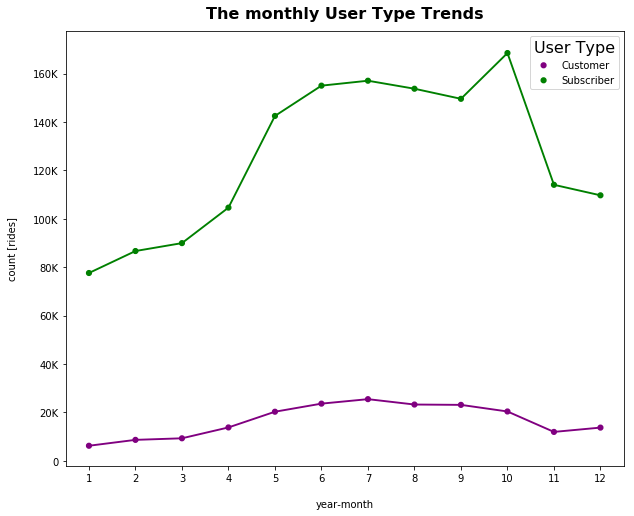

In [6]:
plt.figure(figsize=(10,8))
colors = {'Subscriber':'Green', 'Customer':'purple'}
ax = sns.pointplot(x='st_month', y=0, hue='user_type', palette=colors, scale=.7, data=usertype_count_df)
plt.title('The monthly User Type Trends', fontsize=16, y=1.015,fontweight='semibold')
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))

### Percentage of Bike Rides by Age Group:

In [9]:
#Generate a new column member_age_bins from member age group
df_clean['member_age_bins'] = df_clean['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

In [10]:
trip_agegroup_df = df_clean.groupby('member_age_bins').agg({'bike_id':'count'})
trip_agegroup_df['percentage'] = (trip_agegroup_df['bike_id']/trip_agegroup_df['bike_id'].sum())*100

70 % of 20-40 age group people took more bike rides,of which 40% of 30-40 age group people took more rides compare to all other age groups.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

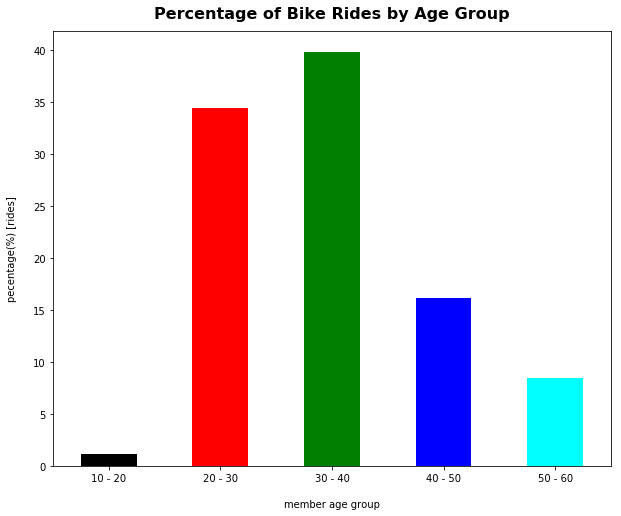

In [11]:
new_color = ['black', 'red', 'green', 'blue', 'cyan']
trip_agegroup_df['percentage'].plot(kind='bar', color=new_color, figsize=(10,8))
plt.title('Percentage of Bike Rides by Age Group', fontsize=16, y=1.015,fontweight='semibold')
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)

### Percentage of Bike Rides by Gender:

In [12]:
ride_gender_df = df_clean.groupby('member_gender').agg({'bike_id':'count'})
ride_gender_df['percentage'] = (ride_gender_df['bike_id']/ride_gender_df['bike_id'].sum())*100

Mostly 76% of male members took more rides compare to percentage of female riders and others.

(0, 100)

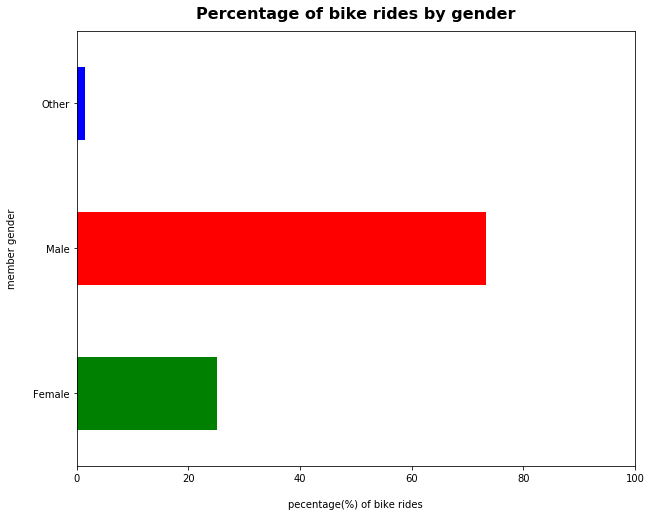

In [13]:
new_color = ['green', 'red', 'blue']
ride_gender_df['percentage'].plot(kind='barh', color=new_color, figsize=(10,8))
plt.title('Percentage of bike rides by gender', fontsize=16, y=1.015,fontweight='semibold')
plt.ylabel('member gender', labelpad=16)
plt.xlabel('pecentage(%) of bike rides', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)

### Customers vs Subscribers usage during Weekdays and Hours:
Customers mostly use the service after 10 am to 7pm where as subscribers use the service between 8-9 am and 5-6 pm from Monday to Friday. Customers use most service during weekends compare to Subscribers.

### Average Trip duration and Distance:
Customers had longer trip duration around 28 minutes when compare to Subscribers who took average trip duration around 12 mins. Also  Customers took extra mile trip compare to Subscribers which is 1 mile difference.


In [14]:
#Calculate distance in miles
def distance(origin, destination):
    """
    Parameters
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [15]:
# Convert Kms to Miles
df_clean['distance_kms'] = df_clean.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df_clean['distance_miles'] = df_clean['distance_kms']*0.621371

Text(0.5, 0, 'distance in miles')

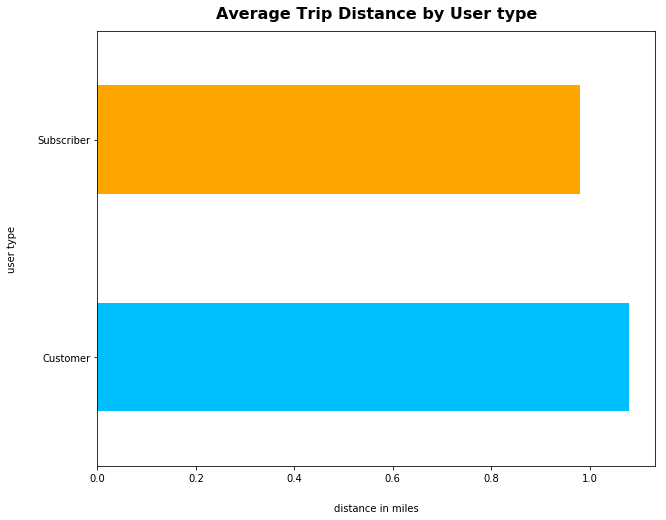

In [16]:
new_color= ['deepskyblue','orange']
ax = df_clean.groupby('user_type')['distance_miles'].mean().plot(kind='barh', color=new_color, figsize=(10,8))
ax.set_title('Average Trip Distance by User type', fontsize=16, y=1.015,fontweight='semibold')
ax.set_ylabel('user type', labelpad=20)
ax.set_xlabel('distance in miles', labelpad=20)

### Monthly  Bike Trends by user type and gender:
From Monthly Trends for both customers and subscribers trips shows that Males utilizing more service compare to Females and others. Both Customers and Subscribers rides increase during summer time from May to October and decrease during Winter season.

### Subscribers and Customers Monthly Bike trips by Member Age Group: 
From both user types:Subscribers and Customers most common behavior is that mostly 20-40 age groups are actively using service compare to other age groups like old people between 40-60.

### Subscribers vs Customers Bike Trends by Age Gender,Weekdays, Hours Analysis:
Subscribers are most frequently used this service around 7-9am and 4-6pm between Monday to Friday and use less service during weekends.Customers use this service during weekend for leisure and weekdays after work.

### Subscribers Bike Trends by Age Gender,Weekdays, Hours Analysis:

In [17]:
# Extract Subscribers age groups between 20 and 60
subscriber_df01 = df_clean[(df_clean['member_age']>=20) & (df_clean['member_age']<60) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Subscriber')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [18]:
#Extract Subscribers age groups between 20 and 30
subscriber_df2 = df_clean[(df_clean['member_age']>=20) & (df_clean['member_age']<30) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Subscriber')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [19]:
# Extract Subscribers age groups between 30 and 40
subscriber_df3 = df_clean[(df_clean['member_age']>=30) & (df_clean['member_age']<40) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Subscriber')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()


In [20]:
# Extract Subscribers age groups between 40 and 50
subscriber_df4 = df_clean[(df_clean['member_age']>=40) & (df_clean['member_age']<50) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Subscriber')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [21]:
# Extract Weekdays for age groups between 20 and 30
subscriber_df2['st_weekday'] = pd.Categorical(subscriber_df2['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [22]:
# Extract Weekdays for age groups between 30 and 40
subscriber_df3['st_weekday'] = pd.Categorical(subscriber_df3['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [23]:
# Extract Weekdays for age groups between 40 and 50
subscriber_df4['st_weekday'] = pd.Categorical(subscriber_df4['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [24]:
# Calculate Percentage for 20 to 30 age groups
subscriber_df2['count_percentage'] = subscriber_df2['count'].apply(lambda x: (x/subscriber_df01['count'].sum())*100)

In [25]:
# Calculate Percentage for 30 to 40 age groups
subscriber_df3['count_percentage'] = subscriber_df3['count'].apply(lambda x: (x/subscriber_df01['count'].sum())*100)

In [26]:
# Calculate Percentage for 40 to 50 age groups
subscriber_df4['count_percentage'] = subscriber_df4['count'].apply(lambda x: (x/subscriber_df01['count'].sum())*100)

In [27]:
# Calculate Rank in ascending order for 20 to 30 age groups
subscriber_df2['rank'] = subscriber_df2['count_percentage'].rank(ascending=False).astype(int)

In [28]:
# Calculate Rank in ascending order for 30 to 40 age groups
subscriber_df3['rank'] = subscriber_df3['count_percentage'].rank(ascending=False).astype(int)

In [29]:
# Calculate Rank in ascending order for 40 to 50 age groups
subscriber_df4['rank'] = subscriber_df4['count_percentage'].rank(ascending=False).astype(int)

In [30]:
# Create Pivot table for 20 to 30 age groups
subscriber_pivot02 = subscriber_df2.pivot_table(index='st_hour', columns='st_weekday', values='rank')

In [31]:
# Create Pivot table for 30 to 40 age groups
subscriber_pivot03 = subscriber_df3.pivot_table(index='st_hour', columns='st_weekday', values='rank')

In [32]:
# Create Pivot table for 40 to 50 age groups
subscriber_pivot04 = subscriber_df4.pivot_table(index='st_hour', columns='st_weekday', values='rank')

Subscribers of 20-40 years age group use the service from Monday to Friday between 7am -10am and 4pm-8pm. 40-50 years use between 7am-10am and 3pm-7pm.Subscribers use less service during weekends.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

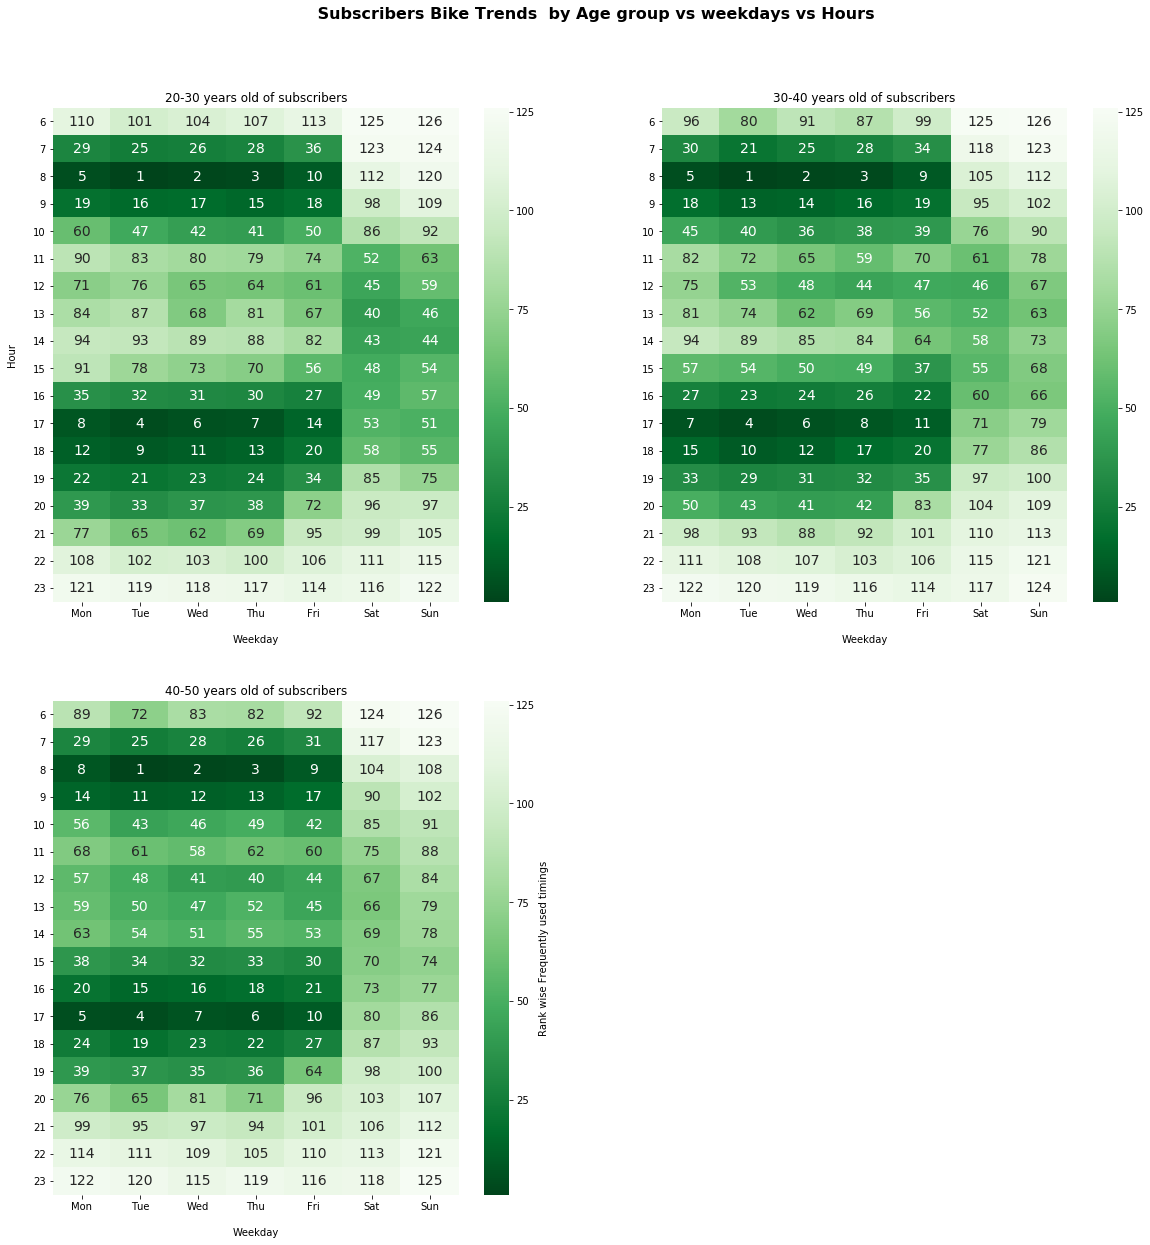

In [34]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle(' Subscribers Bike Trends  by Age group vs weekdays vs Hours', fontsize=16,fontweight='semibold', y=0.95)
sns.heatmap(subscriber_pivot02, fmt='d', annot=True, cmap='Greens_r', annot_kws={"size": 14})
plt.title("20-30 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(subscriber_pivot03, fmt='d', annot=True, cmap='Greens_r', annot_kws={"size": 14})
plt.title("30-40 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(subscriber_pivot04, fmt='d', annot=True, cmap='Greens_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank wise Frequently used timings'})
plt.title("40-50 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

### Customers Bike Trends by Age Gender,Weekdays, Hours Analysis:

In [35]:
# Extract Customer age groups between 20 to 60
customer_df01 = df_clean[(df_clean['member_age']>=20) & (df_clean['member_age']<60) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Customer')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [36]:
# Extract Customer age groups between 20 to 30
customer_df2 = df_clean[(df_clean['member_age']>=20) & (df_clean['member_age']<30) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Customer')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [37]:
# Extract Customer age groups between 30 to 40
customer_df3 = df_clean[(df_clean['member_age']>=30) & (df_clean['member_age']<40) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Customer')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()


In [38]:
# Extract Customer age groups between 40 to 50
customer_df4 = df_clean[(df_clean['member_age']>=40) & (df_clean['member_age']<50) 
                              &(df_clean['st_hour']>5)&(df_clean['user_type']=='Customer')
                             ].groupby(['st_weekday', 'st_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [39]:
# Extract Weekdays for 20-30 age groups
customer_df2['st_weekday'] = pd.Categorical(customer_df2['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [40]:
# Extract Weekdays for 30-40 age groups
customer_df3['st_weekday'] = pd.Categorical(customer_df3['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [41]:
# Extract Weekdays for 40-50 age groups
customer_df4['st_weekday'] = pd.Categorical(customer_df3['st_weekday'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [42]:
# Calculate Percentage for 20-30 age groups
customer_df2['count_percentage'] = customer_df2['count'].apply(lambda x: (x/customer_df01['count'].sum())*100)

In [43]:
# Calculate Percentage for 30-40 age groups
customer_df3['count_percentage'] = customer_df3['count'].apply(lambda x: (x/customer_df01['count'].sum())*100)

In [44]:
# Calculate Percentage for 40-50 age groups
customer_df4['count_percentage'] = customer_df4['count'].apply(lambda x: (x/customer_df01['count'].sum())*100)

In [45]:
# Calculate Rank for 20-30 age groups
customer_df2['rank'] = customer_df2['count_percentage'].rank(ascending=False).astype(int)

In [46]:
# Calculate Rank for 30-40 age groups
customer_df3['rank'] = customer_df3['count_percentage'].rank(ascending=False).astype(int)

In [47]:
# Calculate Rank for 40-50 age groups
customer_df4['rank'] = customer_df4['count_percentage'].rank(ascending=False).astype(int)

In [48]:
# Create Pivot table for 20-30 age group 
customer_pivot02 = customer_df2.pivot_table(index='st_hour', columns='st_weekday', values='rank')

In [49]:
# Create Pivot table for 30-40 age group 
customer_pivot03 = customer_df3.pivot_table(index='st_hour', columns='st_weekday', values='rank')

In [50]:
# Create Pivot table for 40-50 age group 
customer_pivot04 = customer_df4.pivot_table(index='st_hour', columns='st_weekday', values='rank')

Customers of 20- 50 years age group use the service from Monday to Friday during morning hours between 8-9 am and 12pm-8pm.There are more active during Weekends. However, 40-50 yrs age group take less rides compare to all other age groups.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

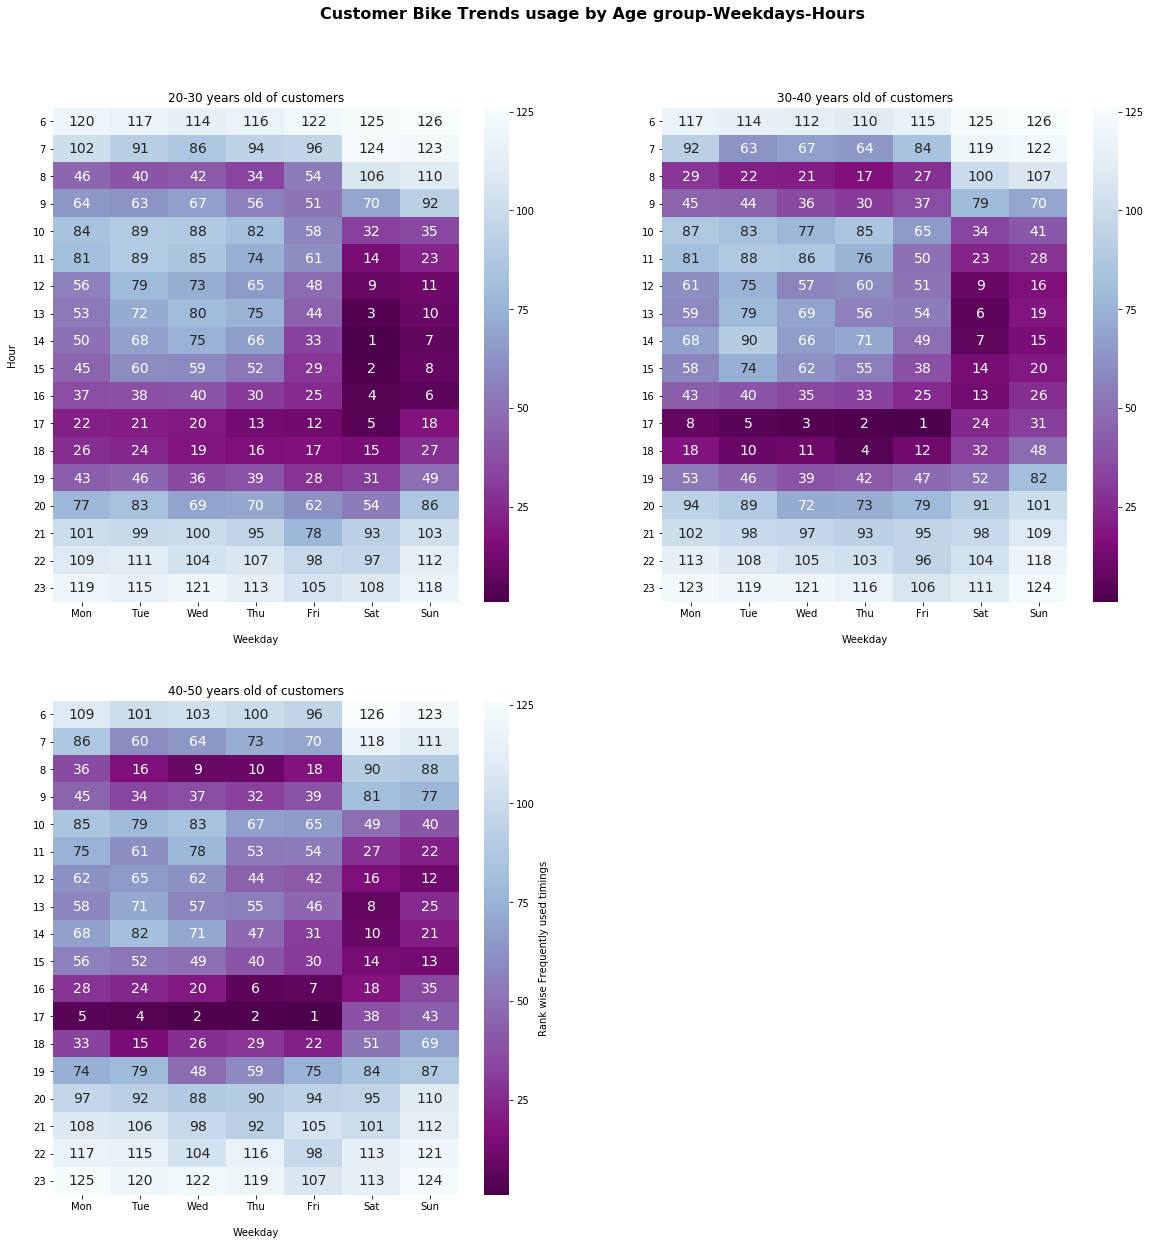

In [51]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle('Customer Bike Trends usage by Age group-Weekdays-Hours', fontsize=16, y=0.95, fontweight='semibold')
sns.heatmap(customer_pivot02, fmt='d', annot=True, cmap='BuPu_r', annot_kws={"size": 14})
plt.title("20-30 years old of customers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(customer_pivot03, fmt='d', annot=True, cmap='BuPu_r', annot_kws={"size": 14})
plt.title("30-40 years old of customers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(customer_pivot04, fmt='d', annot=True, cmap='BuPu_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank wise Frequently used timings'})
plt.title("40-50 years old of customers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)

### Summary: 
Renting a bike from Ford GoBike System is a great initiative of moving around in urban areas, for commute, fun and lesiure purposes. There are two types of users using the service i.e,subscribers are daily commuters, take short trips to and from work, use on weekdays at 8-9am and 5-6pm, and, occasionally around the lunch time, and customers, usually tourists or occassional riders for spending time with family friends who use service on weekends to explore the Bay Area.Finally, Males from both users utilizing more service compare to Females and others. Both Customers and Subscribers rides increase during summer time from May to October and decrease during Winter season.
